In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import gc
import librosa
import pickle

from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model

In [0]:
tf.config.experimental_run_functions_eagerly(True)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
root_dir = "/content/drive/My Drive/"
base_dir = root_dir + 'fma/' # Your own folder 

In [0]:
tracks = pd.read_csv(base_dir + 'fma_metadata/tracks.csv', low_memory=False)
tracks.columns = tracks.iloc[0]
tracks = tracks.drop([0, 1])
new_cols = tracks.columns.values
new_cols[0] = 'track_id'
tracks.columns = new_cols
tracks = tracks.reset_index(drop=True)

In [5]:
tracks.head()

,track_id,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,tags,title,tracks,type,active_year_begin,active_year_end,associated_labels,bio,comments,date_created,favorites,id,latitude,location,longitude,members,name,related_projects,tags,website,wikipedia_page,split,subset,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,genres_all,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.0583238,New Jersey,-74.4056612,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,small,256000,0,NaN,2008-11-26 01:48:12,2008-11-26 00:00:00,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.0583238,New Jersey,-74.4056612,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,medium,256000,0,NaN,2008-11-26 01:48:14,2008-11-26 00:00:00,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.0583238,New Jersey,-74.4056612,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,small,256000,0,NaN,2008-11-26 01:48:20,2008-11-26 00:00:00,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,[],Constant Hitmaker,2,Album,NaN,NaN,"Mexican Summer, Richie Records, Woodsist, Skul...","<p><span style=""font-family:Verdana, Geneva, A...",3,2008-11-26 01:42:55,74,6,NaN,NaN,NaN,"Kurt Vile, the Violators",Kurt Vile,NaN,"['philly', 'kurt vile']",http://kurtvile.com,NaN,training,small,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26 00:00:00,161,178,Pop,[10],[10],NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
4,20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,[],Niris,13,Album,1990-01-01 00:00:00,2011-01-01 00:00:00,NaN,<p>Songs written by: Nicky Cook</p>\n<p>VOCALS...,2,2008-11-26 01:42:52,10,4,51.895927,Colchester England,0.891874,Nicky Cook\n,Nicky Cook,NaN,"['instrumentals', 'experimental pop', 'post pu...",NaN,NaN,training,large,256000,0,NaN,2008-11-26 01:48:56,2008-01-01 00:00:00,311,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


In [15]:
melspec = pickle.load(open(base_dir + 'mel-spec.pkl', 'rb'))
gc.collect()
print(melspec[0])
print(melspec[0].shape)

[[-65.062225 -47.759476 -44.176395 ... -39.408173 -41.73693  -29.414968]
 [-65.40291  -52.760864 -49.179825 ... -16.405546 -16.314037 -17.623047]
 [-69.48193  -56.67646  -50.5069   ... -16.358839 -16.07241  -18.654762]
 ...
 [-79.42308  -59.74297  -36.38287  ... -46.371128 -42.364655 -50.543457]
 [-80.       -63.4197   -41.733234 ... -50.3838   -46.90663  -58.020092]
 [-80.       -73.82068  -52.945995 ... -63.188034 -56.469955 -67.65623 ]]
(128, 646)


In [16]:
melspec_df = pd.DataFrame(melspec)
index_nan = np.argwhere(pd.isnull(melspec))

melspec_df = melspec_df.dropna()
melspec = melspec_df.to_numpy().ravel()

max_dim = 0
for i in melspec:
    if i.shape[1] > max_dim:
        max_dim = i.shape[1]
    else:
        pass
print(max_dim)

647


In [0]:
for i in range(len(melspec)):
    melspec[i] = np.append(melspec[i], 
                           np.zeros((128, max_dim - melspec[i].shape[1])), 
                           axis=1)
    #melspec[i] = melspec[i][:128, :400] # To save memory
    melspec[i] = librosa.util.normalize(melspec[i])
    
index_nan = index_nan.ravel()

In [18]:
print(melspec[0].shape)
del melspec_df
gc.collect()

(128, 647)


427

In [0]:
tracks = tracks.loc[tracks['subset'] == 'small']
tracks = tracks.reset_index()
tracks = tracks.drop(index_nan)
tracks = tracks.reset_index()

In [20]:
y_train = tracks.loc[(tracks['split'] == 'training')]['genre_top']
y_val = tracks.loc[(tracks['split'] == 'validation')]['genre_top']
y_test = tracks.loc[(tracks['split'] == 'test')]['genre_top']

index_train = y_train.index
index_val = y_val.index
index_test = y_test.index
print(index_train)
print(index_val)
print(index_test)
print(len(y_train) + len(y_val) + len(y_test))

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

y_train = keras.utils.to_categorical(y_train, num_classes=8, dtype='int32')
y_val = keras.utils.to_categorical(y_val, num_classes=8, dtype='int32')
y_test = keras.utils.to_categorical(y_test, num_classes=8, dtype='int32')

gc.collect()

Int64Index([   0,    1,    2,    3,    4,    7,    8,    9,   10,   11,
            ...
            7981, 7982, 7983, 7984, 7985, 7986, 7987, 7994, 7995, 7996],
           dtype='int64', length=6397)
Int64Index([   5,   23,   28,   36,   58,   70,  117,  122,  126,  127,
            ...
            7854, 7855, 7856, 7857, 7858, 7859, 7860, 7869, 7871, 7928],
           dtype='int64', length=800)
Int64Index([   6,   39,   40,   41,   42,   43,   44,   55,   56,   64,
            ...
            7951, 7952, 7964, 7965, 7988, 7989, 7990, 7991, 7992, 7993],
           dtype='int64', length=800)
7997


0

In [21]:
melspec = np.stack(melspec.ravel()).reshape(-1, 128, max_dim)
gc.collect()

0

In [22]:
print(melspec.shape)

melspec = melspec.reshape((-1, 128, max_dim, 1))
print(melspec.shape)

print(melspec[0].shape)

(7997, 128, 647)
(7997, 128, 647, 1)
(128, 647, 1)


In [0]:
X_train = melspec[index_train]
X_val = melspec[index_val]
X_test = melspec[index_test]

In [24]:
print(len(X_train))
print(y_train.shape)
print(X_train[0])

6397
(6397, 8)
[[[-0.81327782]
  [-0.64696609]
  [-0.81883592]
  ...
  [-0.73909977]
  [-0.43477104]
  [ 0.        ]]

 [[-0.81753635]
  [-0.7147166 ]
  [-0.91157748]
  ...
  [-0.28889765]
  [-0.2604793 ]
  [ 0.        ]]

 [[-0.86852417]
  [-0.76775859]
  [-0.93617563]
  ...
  [-0.28461879]
  [-0.27572868]
  [ 0.        ]]

 ...

 [[-0.99278851]
  [-0.80929857]
  [-0.67437826]
  ...
  [-0.75021583]
  [-0.7470629 ]
  [ 0.        ]]

 [[-1.        ]
  [-0.85910482]
  [-0.77355047]
  ...
  [-0.83064757]
  [-0.85757209]
  [ 0.        ]]

 [[-1.        ]
  [-1.        ]
  [-0.9813857 ]
  ...
  [-1.        ]
  [-1.        ]
  [ 0.        ]]]


In [0]:
def plot_history(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  
  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

# VGG16

In [26]:
from tensorflow.keras.applications import VGG16

vgg_conv = VGG16(weights='imagenet', 
                 include_top=False, 
                 input_shape=(128, 400, 3))

for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
    
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fd377d3ef60> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd37a25f748> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd37a25ff28> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fd37b4dd2e8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd37b5f7b70> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd37b61f2e8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fd37b0464a8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd37b046320> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd37b036668> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd37bfc0828> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fd377c74748> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

In [27]:
X_train_RGB = X_train.reshape((-1, 128, max_dim))
X_train_RGB = np.repeat(X_train_RGB[..., np.newaxis], 3, -1)
X_train_RGB.shape

(6397, 128, 647, 3)

In [28]:
X_val_RGB = X_val.reshape((-1, 128, max_dim))
X_val_RGB = np.repeat(X_val_RGB[..., np.newaxis], 3, -1)
X_val_RGB.shape

(800, 128, 647, 3)

In [29]:
model = keras.Sequential()

model.add(vgg_conv)

model.add(Flatten())

model.add(Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2()))
model.add(Dropout(0.5))

model.add(Dense(8, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 12, 512)        14714688  
_________________________________________________________________
flatten (Flatten)            (None, 24576)             0         
_________________________________________________________________
dense (Dense)                (None, 16)                393232    
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
Total params: 15,108,056
Trainable params: 7,472,792
Non-trainable params: 7,635,264
_________________________________________________________________


In [0]:
model.compile(optimizer='nadam', 
              loss=keras.losses.CategoricalCrossentropy(), 
              metrics=['acc'])

In [0]:
mcp_save = ModelCheckpoint('best_model_cnn_mel-spec.hdf5', 
                           save_best_only=True, 
                           monitor='val_acc', 
                           mode='max', verbose=1)

history = model.fit(X_train_RGB, y_train, validation_split=0.2, 
                    shuffle = True,
                    epochs=15, verbose=1, callbacks=[mcp_save])

# CNN

In [47]:
model = keras.models.Sequential()

model.add(Conv2D(32, activation='relu', 
                 kernel_size=3, kernel_regularizer=l2(), 
                 strides=1, input_shape=(128,max_dim, 1)))

model.add(Conv2D(3, kernel_size=(13, 10), strides=1, activation="relu"))

model.add(Conv2D(15, kernel_size=(1, 10), strides=1, activation="relu"))

model.add(Conv2D(65, kernel_size=(1, 10), strides=1, activation="relu"))


model.add(Flatten())

model.add(Dense(8, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 645, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 114, 636, 3)       12483     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 114, 627, 15)      465       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 114, 618, 65)      9815      
_________________________________________________________________
flatten (Flatten)            (None, 4579380)           0         
_________________________________________________________________
dense (Dense)                (None, 8)                 36635048  
Total params: 36,658,131
Trainable params: 36,658,131
Non-trainable params: 0
____________________________________________

In [0]:
optimizer = keras.optimizers.SGD(1e-3)

model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=['acc'])

In [49]:
mcp_save = ModelCheckpoint('best_model_cnn_mel-spec.hdf5', 
                           save_best_only=True, 
                           monitor='val_acc', 
                           mode='max', verbose=1)

history = model.fit(X_train, y_train, validation_split=0.1, 
                    shuffle = True,
                    epochs=15, verbose=1, callbacks=[mcp_save])

Epoch 1/15
180/180 [==============================] - ETA: 0s - loss: 2.0925 - acc: 0.1338
Epoch 00001: val_acc improved from -inf to 0.13750, saving model to best_model_cnn_mel-spec.hdf5
180/180 [==============================] - 60s 331ms/step - loss: 2.0925 - acc: 0.1338 - val_loss: 2.0805 - val_acc: 0.1375
Epoch 2/15
180/180 [==============================] - ETA: 0s - loss: 2.0592 - acc: 0.1676
Epoch 00002: val_acc improved from 0.13750 to 0.16719, saving model to best_model_cnn_mel-spec.hdf5
180/180 [==============================] - 58s 322ms/step - loss: 2.0592 - acc: 0.1676 - val_loss: 2.0394 - val_acc: 0.1672
Epoch 3/15
180/180 [==============================] - ETA: 0s - loss: 1.9855 - acc: 0.2352
Epoch 00003: val_acc improved from 0.16719 to 0.25156, saving model to best_model_cnn_mel-spec.hdf5
180/180 [==============================] - 58s 322ms/step - loss: 1.9855 - acc: 0.2352 - val_loss: 1.9682 - val_acc: 0.2516
Epoch 4/15
180/180 [==============================] - ETA:

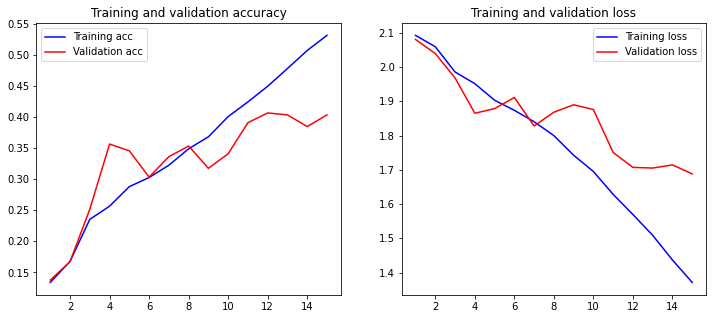

In [50]:
plot_history(history)

In [51]:
best_model = load_model('best_model_cnn_mel-spec.hdf5')
print("Train:")
print(best_model.evaluate(X_train, y_train, verbose=2))
print("Val:")
print(best_model.evaluate(X_val, y_val, verbose=2))

Train:
200/200 - 15s - loss: 1.4975 - acc: 0.4916
[1.4974526166915894, 0.4916366934776306]
Val:
25/25 - 2s - loss: 1.6951 - acc: 0.3775
[1.6951380968093872, 0.3774999976158142]


In [0]:
dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 
               'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7  }

In [62]:
from sklearn.metrics import classification_report

#y_val = np.argmax(y_val, axis = 1)
y_pred = model.predict_classes(X_val)
#y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()

print(y_val.shape, y_pred.shape)

(800,) (800,)


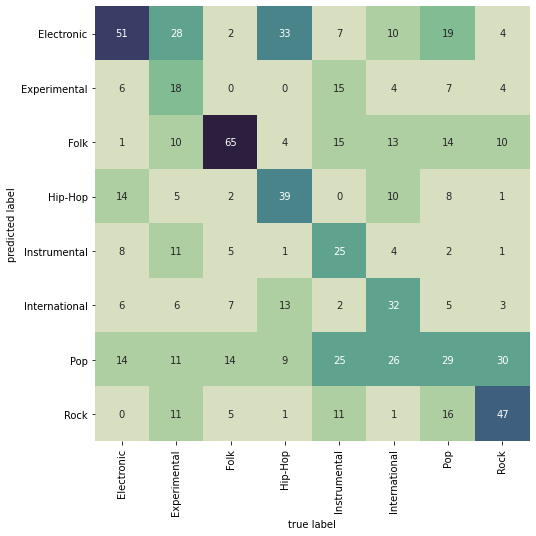

In [72]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mat = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8,8))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            cmap=sns.cubehelix_palette(8, start=.5, rot=-.75),
            xticklabels=dict_genres.keys(),
            yticklabels=dict_genres.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');

### Test

In [82]:
from sklearn.metrics import classification_report

y_pred = model.predict_classes(X_test)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()

print(y_test.shape, y_pred.shape)

(800, 8) (800,)


In [83]:
print(classification_report(y_val, y_pred, target_names=target_names))

               precision    recall  f1-score   support

   Electronic       0.13      0.19      0.15       100
 Experimental       0.12      0.12      0.12       100
         Folk       0.13      0.17      0.15       100
      Hip-Hop       0.02      0.02      0.02       100
 Instrumental       0.12      0.07      0.09       100
International       0.15      0.10      0.12       100
          Pop       0.14      0.18      0.16       100
         Rock       0.14      0.10      0.12       100

     accuracy                           0.12       800
    macro avg       0.12      0.12      0.12       800
 weighted avg       0.12      0.12      0.12       800



In [87]:
y_test

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [89]:
y_val

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int32)

In [90]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,8))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            cmap=sns.cubehelix_palette(8, start=.5, rot=-.75),
            xticklabels=dict_genres.keys(),
            yticklabels=dict_genres.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');

ValueError: ignored

In [0]:
from sklearn.metrics import classification_report

y_test = np.argmax(y_valid, axis = 1)
y_pred = model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()

print(y_test.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

In [0]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))

In [0]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=dict_genres.keys(),
            yticklabels=dict_genres.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');

In [0]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(8):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])